# Making custom colour maps
---
This notebook is part 5/5 of a tutorial based on the [```colourspace```](https://github.com/gillesferrand/colourspace) package.

In [1]:
from colourspace import convert, maps

convertor = 'custom' (illuminant = 'D65')


In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import pylab as plt

The ```maps``` module deals with the custom generation of colour maps. A colour map is a mapping from a range of values (say, the interval [0,1]) to a set of colours (each defined by a triplet of coordinates), that is, a colour map is a parametrized path in the 3D colour space. To design perceptually-correct colour maps, we will draw the path in LCH space, and convert it to the machine RGB space. For example, for a grayscale:

In [3]:
N = 100
L_range = np.linspace(0,100,N) # linear ramp
C_range = np.zeros(N) # C = radius = 0: stay on the central axis
H_range = np.zeros(N) # H = direction is then irrelevant
RGB_list = convert.clip3(convert.LCH2RGB(L_range,C_range,H_range))
print(RGB_list.shape)

(100, 3)


To see the RGB list as an image, we need to promote it to a M×N×3 array

In [4]:
height = 10
#RGB_array = np.array([RGB_list,]*height)
RGB_array = np.tile(RGB_list, (height,1,1))
print(RGB_array.shape)

(10, 100, 3)


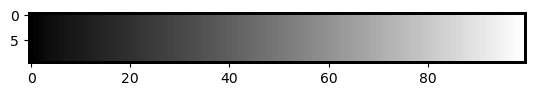

In [5]:
plt.imshow(RGB_array)

To actually use it as a colour map, we generate a Matplotlib cmap object from the RGB list.

In [6]:
mycmap = matplotlib.colors.ListedColormap(RGB_list)

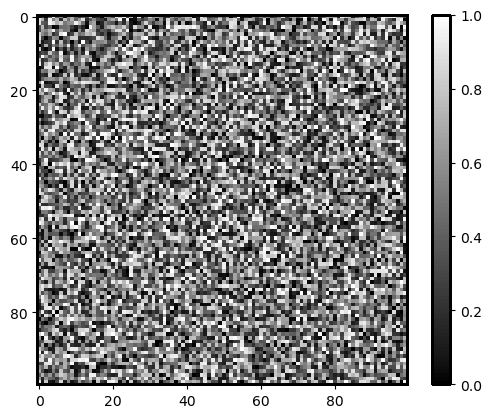

In [7]:
data = np.random.rand(100,100)
plt.imshow(data, cmap=mycmap, vmin=0, vmax=1)
plt.colorbar()

In the module both are taken care of by the function `generate_cmaps(RGB_list,name,targets)`, which will <br>
\- write the cmap as a PNG image file if `'png'` is in `targets` (with a width equal to the number of steps, and an arbitrary height); <br>
\- turn it into a Matplotlib cmap object if `'mpl'` is in `targets`, stored in the `CMAP` dictionary. (A colour map may also be added to Matplotlib's internal list of cmaps using `register_to_mpl()`.) 
The function `get_cmap()` returns a named colour map, looking first in the local cache `CMAP`, then in Matplotlib's registered colours, optionally resampled with `nsteps` bins.<br>
The convenience function `make_cmap_path(L,C,H)` takes L,C,H arrays, converts them to R,G,B and generates the cmap.

The package also include helper functions to see the path taken by a cmap in colour space. `plot_path(cmap,space,stack)` takes for argument a Matplotlib cmap (by name, or the object), it extracts the curves R,G,B or L,C,H according to the selected `space`, and displays the three curves according to `stack`: H = horizontally, V = vertically, Z = in depth. If working in LCH, it adds to the C plot the sRGB gamut boundary (that is, for each step, the Cmax for the current L and H). It can also add an image of the cmap itself as the abscissa. The line properties can be configured, per dimension (by default the colour dimensions are colour-coded); axes objects are returned and can be re-used for overplotting other cmaps.

loading gamut from /Users/gferrand/simus/colour/colourspace/gamut/Cmax_res10_sRGB.npy


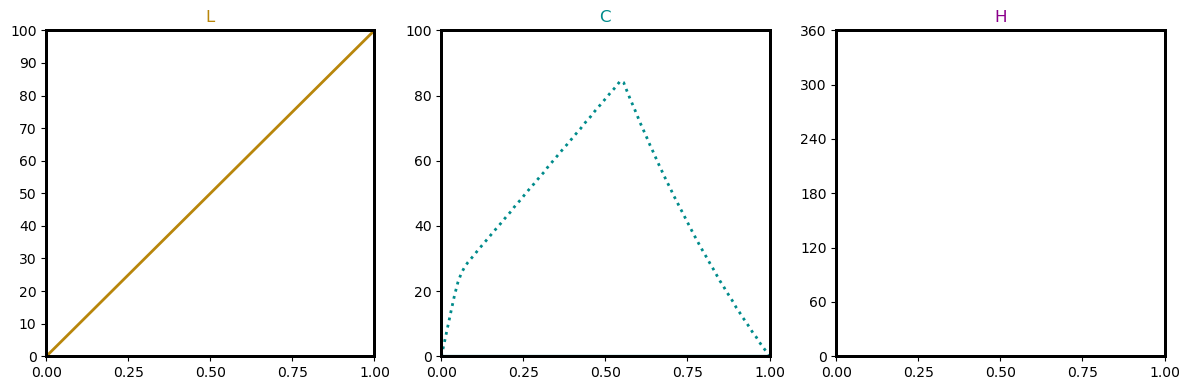

In [8]:
axes = maps.plot_path(mycmap, space='LCH', stack='H', widths=[2])

The curves are trivial for a grayscale. Note that when C=0 the value computed for H is arbitrary, by default it is not plotted (when not all C=0, missing values for H may be interpolated, see parameter `H_patch`).

---
Working in LCH allows us to manipulate independently the three dimensions of colour: lightness, chroma, hue. We will demonstrate this with three kinds of cmaps, that cannot be easily produced when working in RGB or its derivatives:
- equi-luminant, stepping in H at Cmax
- diverging, stepping in C at a given L from one H to another
- mono-hue, stepping in L at Cmax

For each of the three cmap making functions used below, `res` is the number of steps per unit of the quantity L,C,H that is being stepped through.<br> 
As before, colours out of the sRGB gamut are discarded if `mode='crop'`, or just have their values clipped if `mode='clip'` (`'clip'` cmaps are more vivid, but less uniform, than `'crop'` cmaps). 

Function ```make_cmap_favs(types,modes,targets)``` generates and writes a set of predefined cmaps of the above types. (Note that, for each case in ```types```, the ```CMAP``` dictionary will be reset.)

Function `test_cmaps()` can be used to test the cmaps, listed by name, on mock data.

In [9]:
figsize_test = (6, 6)

Function ```plot_cmaps()``` plots all the cmaps present in ```CMAP```, and writes them as PNG images of normalized width and height.

In [10]:
figsize_cmp_x = 10
figsize_cmp_y = 0.8

In [11]:
png_dir = "./maps"
dpi = 200

## Equi-luminant cmaps

Function ```make_cmap_equilum()``` draws a curve at constant L in the LH plane, in the chosen H range, at the Cmax for this L.

In [12]:
maps.make_cmap_equilum(L=70, H=[0,360], Hres=1, png_dir=png_dir)

loading gamut from /Users/gferrand/simus/colour/colourspace/gamut/Cmax_res10_full.npy
creating cmap 'equilum_L070_H000-360_clip' for Matplotlib ( 361 steps)
writing ./maps/cmap_equilum_L070_H000-360_clip.png (32x361)
creating cmap 'equilum_L070_H000-360_crop' for Matplotlib ( 361 steps)
writing ./maps/cmap_equilum_L070_H000-360_crop.png (32x361)


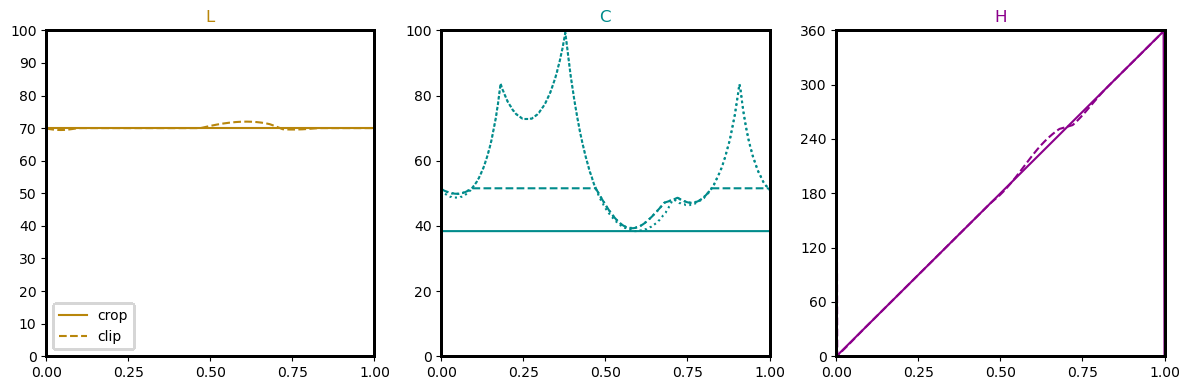

In [13]:
axes = maps.plot_path("equilum_L070_H000-360_crop", space='LCH', stack='H', axes=[]  , styles=['-' ], legend_label='crop')
axes = maps.plot_path("equilum_L070_H000-360_clip", space='LCH', stack='H', axes=axes, styles=['--'], legend_label='clip', legend_loc='lower left')

When working in `crop` mode (solid lines), we are restricting ourselves to the sRGB gamut from the start, and so we get exactly what we asked for. When working in `clip` mode (dashed lines), we are using the same recipes, but in the full human gamut, which is too large for any display, so inevitably some colours are irrepresentable and get clipped into the sRGB gamut — when this happens, uncontrolled shifts occur in all 3 dimensions L,C,H.

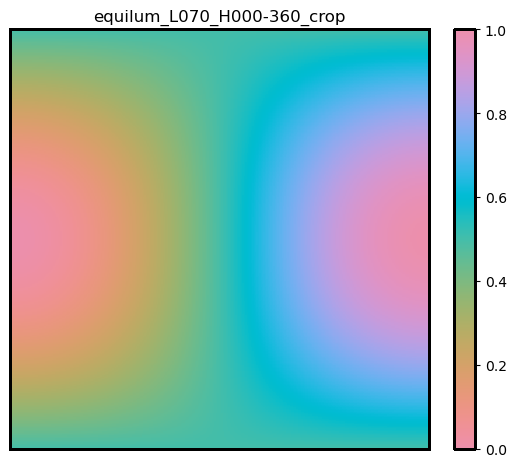

In [14]:
maps.test_cmaps(names=["equilum_L070_H000-360_crop"],figsize=figsize_test,fname="")

Because the eye cannot see clear edges, the colours may seem to be vibrating. Such a colour map is maybe more useful for discrete sampling, e.g. applied to a set of curves. Its interest is to produce a rainbow palette that is far more uniform than the one made in RGB.

In [15]:
maps.make_cmap_equilum(L=70, H=[0,290], Hres=1, png_dir=png_dir)

creating cmap 'equilum_L070_H000-290_clip' for Matplotlib ( 291 steps)
writing ./maps/cmap_equilum_L070_H000-290_clip.png (32x291)
creating cmap 'equilum_L070_H000-290_crop' for Matplotlib ( 291 steps)
writing ./maps/cmap_equilum_L070_H000-290_crop.png (32x291)


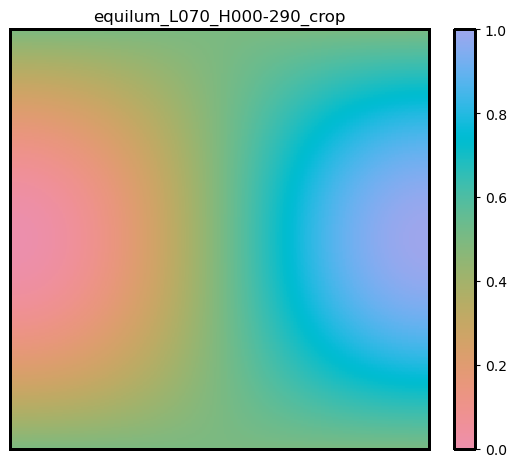

In [16]:
maps.test_cmaps(names=["equilum_L070_H000-290_crop"],figsize=figsize_test,fname="")

Note: any continuous cmap can be made discrete (binned) by resampling its colours, this is offered with the optional parameter ```nstep```.

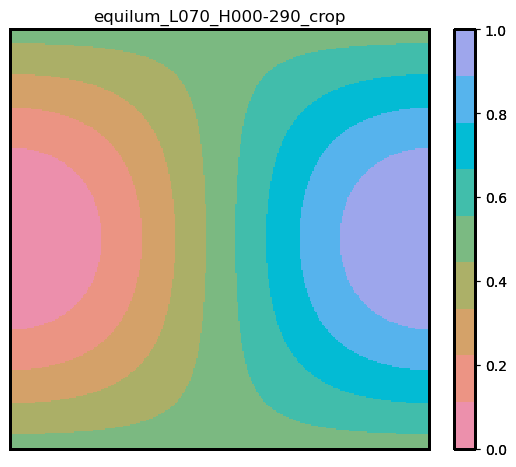

In [17]:
maps.test_cmaps(names=["equilum_L070_H000-290_crop"]*2,nsteps=[10,9],figsize=figsize_test,fname="")

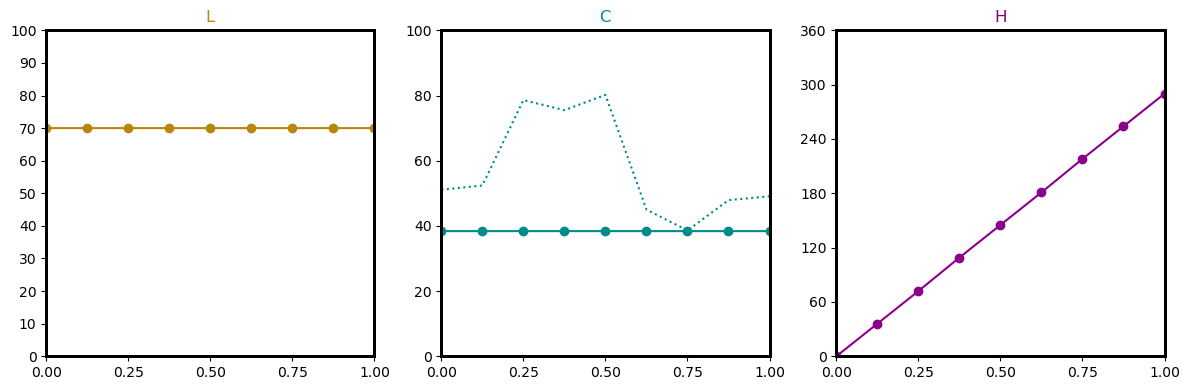

In [18]:
axes = maps.plot_path("equilum_L070_H000-290_crop", nsteps=9, space='LCH', stack='H', markers='o')

A more limited range:

In [19]:
maps.make_cmap_equilum(L=70, H=[240,0], Hres=1, png_dir=png_dir)

creating cmap 'equilum_L070_H240-000_clip' for Matplotlib ( 122 steps)
writing ./maps/cmap_equilum_L070_H240-000_clip.png (32x122)
creating cmap 'equilum_L070_H240-000_crop' for Matplotlib ( 122 steps)
writing ./maps/cmap_equilum_L070_H240-000_crop.png (32x122)


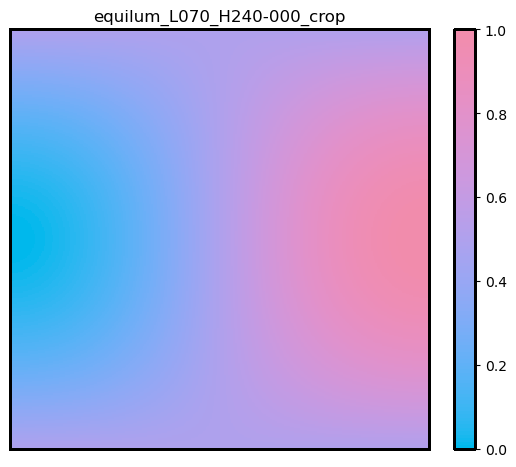

In [20]:
maps.test_cmaps(names=["equilum_L070_H240-000_crop"],figsize=figsize_test,fname="")

A selection

In [21]:
maps.make_cmap_favs(types=['equilum'], modes=['crop','clip'], targets=['mpl'], plot=False)

-------
equilum
-------
creating cmap 'equilum_L020_H000-250_crop' for Matplotlib ( 501 steps)
creating cmap 'equilum_L030_H000-250_crop' for Matplotlib ( 501 steps)
creating cmap 'equilum_L040_H000-250_crop' for Matplotlib ( 501 steps)
creating cmap 'equilum_L050_H000-250_crop' for Matplotlib ( 501 steps)
creating cmap 'equilum_L060_H000-250_crop' for Matplotlib ( 501 steps)
creating cmap 'equilum_L070_H000-250_crop' for Matplotlib ( 501 steps)
creating cmap 'equilum_L080_H000-250_crop' for Matplotlib ( 501 steps)
creating cmap 'equilum_L020_H000-250_clip' for Matplotlib ( 501 steps)
creating cmap 'equilum_L030_H000-250_clip' for Matplotlib ( 501 steps)
creating cmap 'equilum_L040_H000-250_clip' for Matplotlib ( 501 steps)
creating cmap 'equilum_L050_H000-250_clip' for Matplotlib ( 501 steps)
creating cmap 'equilum_L060_H000-250_clip' for Matplotlib ( 501 steps)
creating cmap 'equilum_L070_H000-250_clip' for Matplotlib ( 501 steps)
creating cmap 'equilum_L080_H000-250_clip' for Matplo

found cmaps:  ['equilum_L080_H000-250_crop', 'equilum_L070_H000-250_crop', 'equilum_L060_H000-250_crop', 'equilum_L050_H000-250_crop', 'equilum_L040_H000-250_crop', 'equilum_L030_H000-250_crop', 'equilum_L020_H000-250_crop']
writing  ./maps/cmap256_equilum_L080_H000-250_crop.png
writing  ./maps/cmap256_equilum_L070_H000-250_crop.png
writing  ./maps/cmap256_equilum_L060_H000-250_crop.png
writing  ./maps/cmap256_equilum_L050_H000-250_crop.png
writing  ./maps/cmap256_equilum_L040_H000-250_crop.png
writing  ./maps/cmap256_equilum_L030_H000-250_crop.png
writing  ./maps/cmap256_equilum_L020_H000-250_crop.png
writing  ./maps/cmaps_equi-luminant colour maps (crop mode).png


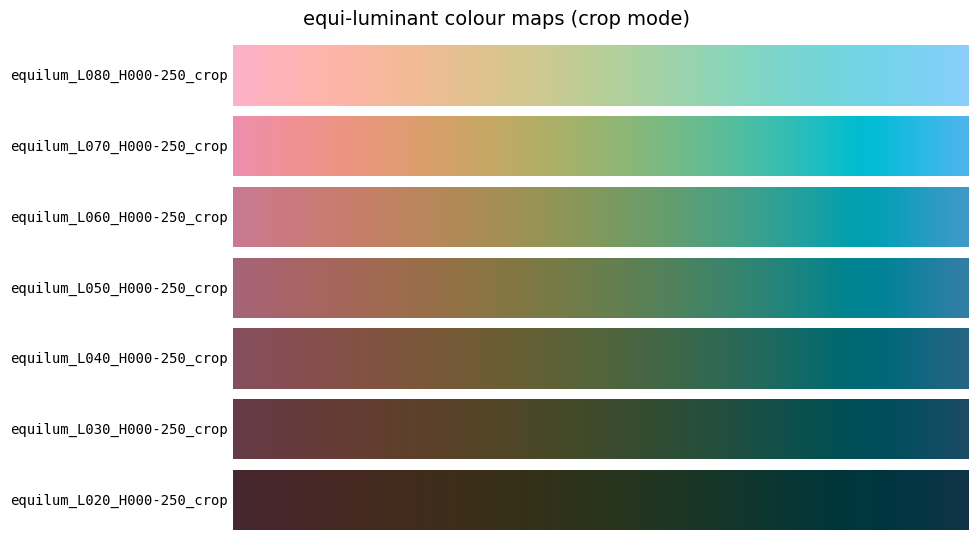

In [22]:
maps.plot_cmaps(filters=['crop'],figsize=(figsize_cmp_x,figsize_cmp_y*7), dpi=dpi, dir=png_dir, title="equi-luminant colour maps (crop mode)")

found cmaps:  ['equilum_L080_H000-250_clip', 'equilum_L070_H000-250_clip', 'equilum_L060_H000-250_clip', 'equilum_L050_H000-250_clip', 'equilum_L040_H000-250_clip', 'equilum_L030_H000-250_clip', 'equilum_L020_H000-250_clip']
writing  ./maps/cmap256_equilum_L080_H000-250_clip.png
writing  ./maps/cmap256_equilum_L070_H000-250_clip.png
writing  ./maps/cmap256_equilum_L060_H000-250_clip.png
writing  ./maps/cmap256_equilum_L050_H000-250_clip.png
writing  ./maps/cmap256_equilum_L040_H000-250_clip.png
writing  ./maps/cmap256_equilum_L030_H000-250_clip.png
writing  ./maps/cmap256_equilum_L020_H000-250_clip.png
writing  ./maps/cmaps_equi-luminant colour maps (clip mode).png


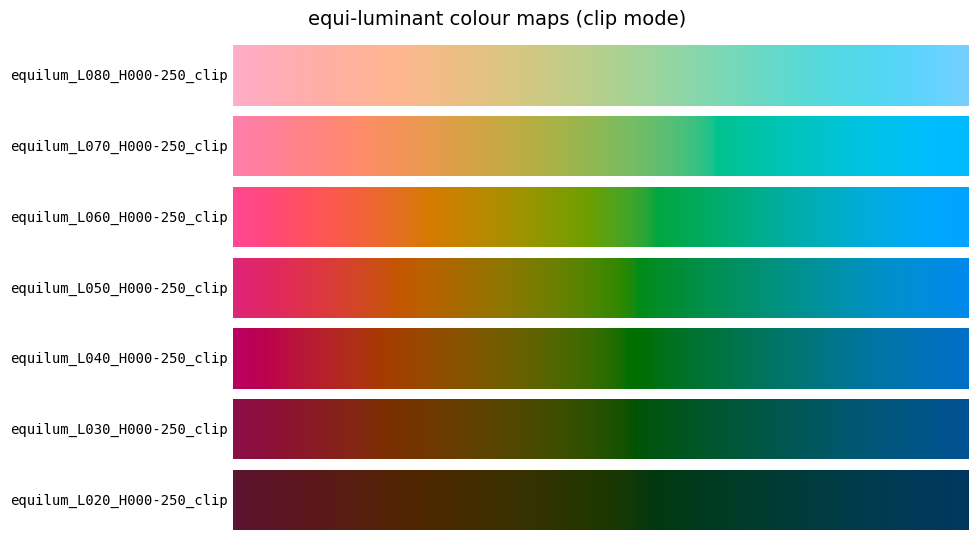

In [23]:
maps.plot_cmaps(filters=['clip'],figsize=(figsize_cmp_x,figsize_cmp_y*7), dpi=dpi, dir=png_dir, title="equi-luminant colour maps (clip mode)")

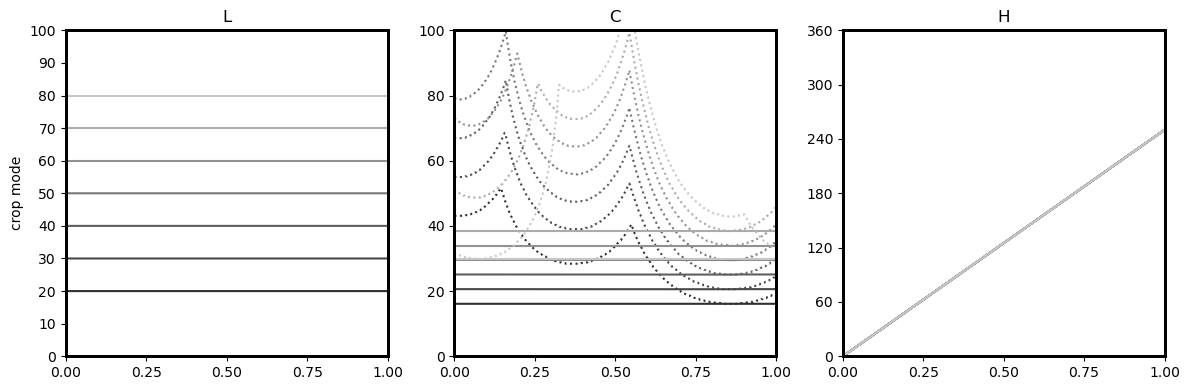

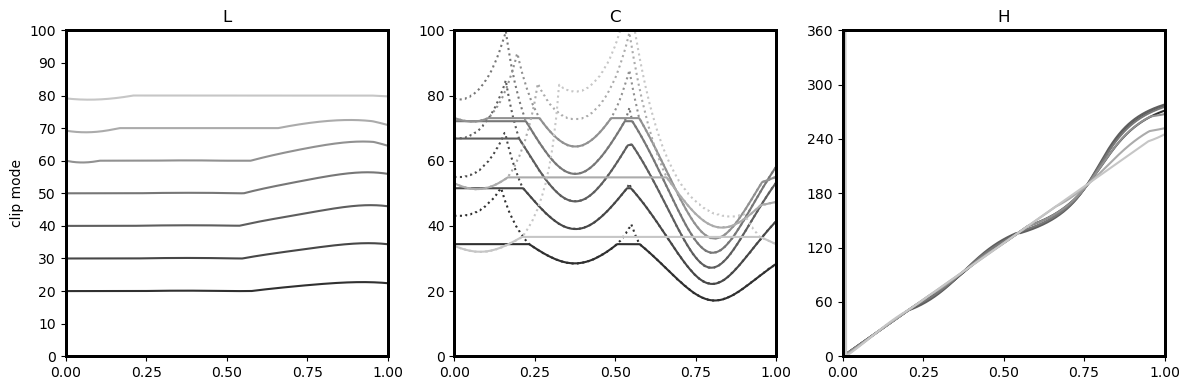

In [24]:
L = np.arange(20,90,10)
for mode in ['crop','clip']:
    axes=[]
    for i in range(len(L)):
        RGB_i = convert.LCH2RGB(L[i],0,0)
        axes = maps.plot_path("equilum_L%03i_H000-250_%s"%(L[i],mode), space='LCH', stack='H', axes=axes, colours=[RGB_i], title="%s mode"%mode)

## Diverging cmaps

Function ```make_cmap_diverging()``` draws a path from H1 at max chroma to H2 at max chroma, at a given L
(if ```sym==True``` then Cmax is set for both hues, otherwise for each hue independently).

In [25]:
maps.make_cmap_diverging(H1=30+180, H2=30, L=60, Cres=1, sym=True, png_dir=png_dir)

creating cmap 'diverging_L060_H210-030_clip' for Matplotlib ( 171 steps)
writing ./maps/cmap_diverging_L060_H210-030_clip.png (32x171)
creating cmap 'diverging_L060_H210-030_crop' for Matplotlib (  69 steps)
writing ./maps/cmap_diverging_L060_H210-030_crop.png (32x69)


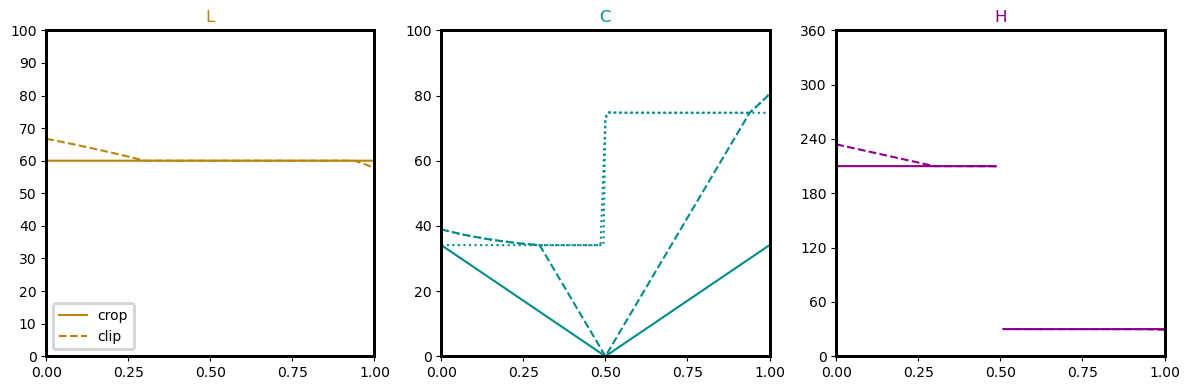

In [26]:
axes = maps.plot_path("diverging_L060_H210-030_crop", space='LCH', stack='H', axes=[]  , styles=['-' ], legend_label='crop')
axes = maps.plot_path("diverging_L060_H210-030_clip", space='LCH', stack='H', axes=axes, styles=['--'], legend_label='clip', legend_loc='lower left')

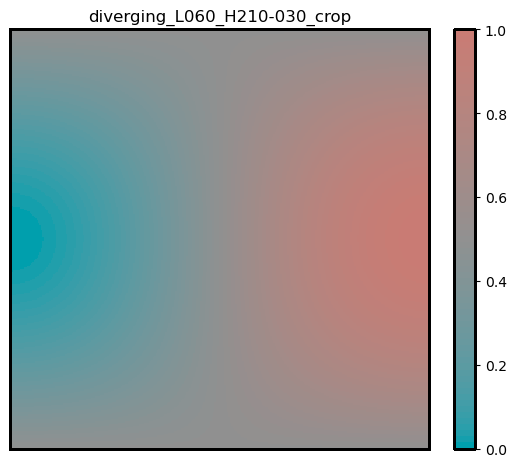

In [27]:
maps.test_cmaps(names=["diverging_L060_H210-030_crop"],figsize=figsize_test,fname="")

Such a colour map is useful for data that have a natural threshold value, e.g. negative and positive values. (The neutral point has to stay anchored at the chosen threshold value, even when the overal range varies.)

The colour map above was made with symmetric chroma on both hue sides. The version below shows that, at this L, the red at H=30 can reach a higher C than the cyan at H=210. 

In [28]:
maps.make_cmap_diverging(H1=30+180, H2=30, L=60, Cres=1, sym=False, png_dir=png_dir)

creating cmap 'diverging_L060_H210-030_clip' for Matplotlib ( 171 steps)
writing ./maps/cmap_diverging_L060_H210-030_clip.png (32x171)
creating cmap 'diverging_L060_H210-030_crop' for Matplotlib (  69 steps)
writing ./maps/cmap_diverging_L060_H210-030_crop.png (32x69)


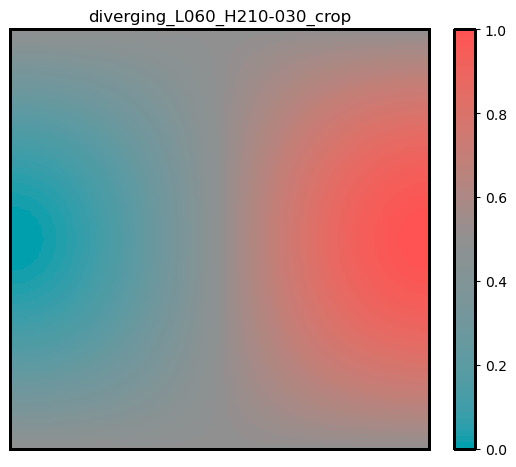

In [29]:
maps.test_cmaps(names=["diverging_L060_H210-030_crop"],figsize=figsize_test,fname="")

creating cmap 'diverging_L060_H210-030_crop' for Matplotlib (  69 steps)
creating cmap 'diverging_L060_H210-030_crop' for Matplotlib (  69 steps)


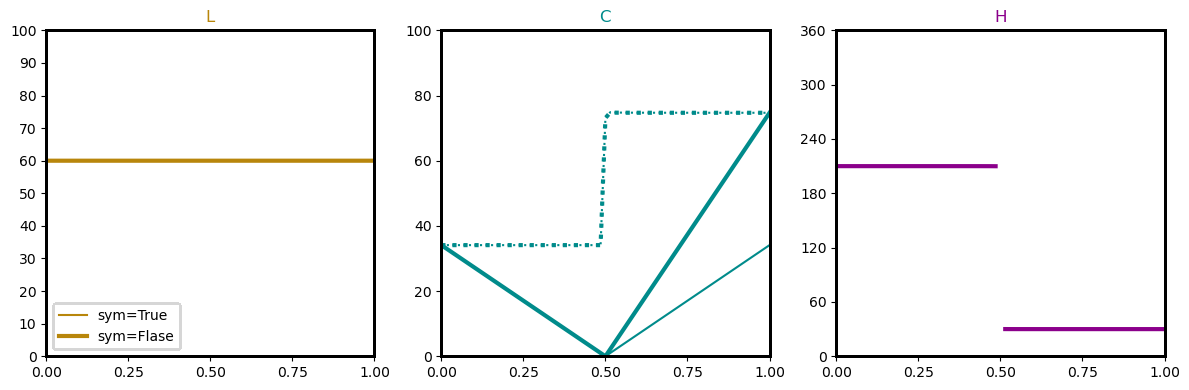

In [30]:
maps.make_cmap_diverging(H1=30+180, H2=30, L=60, Cres=1, sym=True , modes=['crop'], targets=['mpl'])
axes = maps.plot_path("diverging_L060_H210-030_crop", space='LCH', stack='H', axes=[]  , widths=[1.5], legend_label='sym=True', C_tol=0.1)
maps.make_cmap_diverging(H1=30+180, H2=30, L=60, Cres=1, sym=False, modes=['crop'], targets=['mpl'])
axes = maps.plot_path("diverging_L060_H210-030_crop", space='LCH', stack='H', axes=axes, widths=[3.0], legend_label='sym=Flase', legend_loc='lower left')

Diverging cmaps can also be made 2D, with the other axis being the lightness: each row is a 1D cmap like the one plotted above. <br>
Function ```make_cmap_diverging2D()```, for a given range of L, stitches the half planes H=H1 and H=H2 along the gray axis, each extended to Cmax.<br>
(if ```sym==True``` then Cmax is set for both hues, otherwise for each hue independently)

In [31]:
maps.make_cmap_diverging2D(H1=30+180, H2=30, L=[0,100], Lres=1, Csteps=128, png_dir=png_dir)

writing ./maps/cmap_diverging2D_L000-100_H210-030_clip.png (101x257)
writing ./maps/cmap_diverging2D_L000-100_H210-030_crop.png (101x257)


Such bi-variate cmaps may be used manually, but cannot be readily used with Matplotlib (see [issue 4369](https://github.com/matplotlib/matplotlib/issues/4369)).

A selection

In [32]:
maps.make_cmap_favs(types=['diverging'], modes=['crop','clip'], targets=['mpl'], plot=False)

---------
diverging
---------
creating cmap 'diverging_L020_H210-030_crop' for Matplotlib ( 129 steps)
creating cmap 'diverging_L030_H210-030_crop' for Matplotlib ( 165 steps)
creating cmap 'diverging_L040_H210-030_crop' for Matplotlib ( 201 steps)
creating cmap 'diverging_L050_H210-030_crop' for Matplotlib ( 237 steps)
creating cmap 'diverging_L060_H210-030_crop' for Matplotlib ( 273 steps)
creating cmap 'diverging_L070_H210-030_crop' for Matplotlib ( 309 steps)
creating cmap 'diverging_L080_H210-030_crop' for Matplotlib ( 245 steps)
creating cmap 'diverging_L020_H210-030_clip' for Matplotlib ( 447 steps)
creating cmap 'diverging_L030_H210-030_clip' for Matplotlib ( 549 steps)
creating cmap 'diverging_L040_H210-030_clip' for Matplotlib ( 625 steps)
creating cmap 'diverging_L050_H210-030_clip' for Matplotlib ( 669 steps)
creating cmap 'diverging_L060_H210-030_clip' for Matplotlib ( 681 steps)
creating cmap 'diverging_L070_H210-030_clip' for Matplotlib ( 647 steps)
creating cmap 'diverg

found cmaps:  ['diverging_L080_H210-030_crop', 'diverging_L070_H210-030_crop', 'diverging_L060_H210-030_crop', 'diverging_L050_H210-030_crop', 'diverging_L040_H210-030_crop', 'diverging_L030_H210-030_crop', 'diverging_L020_H210-030_crop']
writing  ./maps/cmap256_diverging_L080_H210-030_crop.png
writing  ./maps/cmap256_diverging_L070_H210-030_crop.png
writing  ./maps/cmap256_diverging_L060_H210-030_crop.png
writing  ./maps/cmap256_diverging_L050_H210-030_crop.png
writing  ./maps/cmap256_diverging_L040_H210-030_crop.png
writing  ./maps/cmap256_diverging_L030_H210-030_crop.png
writing  ./maps/cmap256_diverging_L020_H210-030_crop.png
writing  ./maps/cmaps_diverging colour maps (crop mode).png


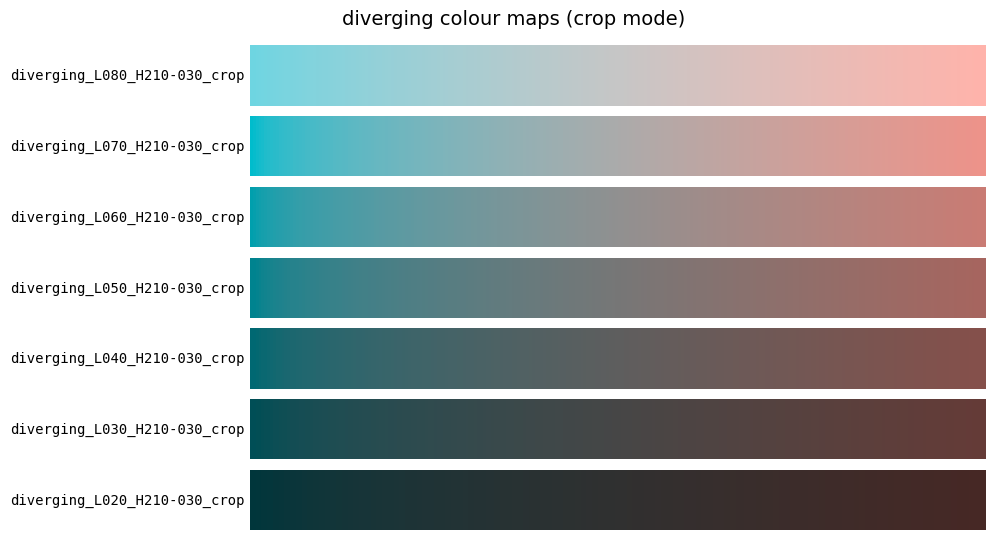

In [33]:
maps.plot_cmaps(filters=['crop'],figsize=(figsize_cmp_x,figsize_cmp_y*7), dpi=dpi, dir=png_dir, title="diverging colour maps (crop mode)")

found cmaps:  ['diverging_L080_H210-030_clip', 'diverging_L070_H210-030_clip', 'diverging_L060_H210-030_clip', 'diverging_L050_H210-030_clip', 'diverging_L040_H210-030_clip', 'diverging_L030_H210-030_clip', 'diverging_L020_H210-030_clip']
writing  ./maps/cmap256_diverging_L080_H210-030_clip.png
writing  ./maps/cmap256_diverging_L070_H210-030_clip.png
writing  ./maps/cmap256_diverging_L060_H210-030_clip.png
writing  ./maps/cmap256_diverging_L050_H210-030_clip.png
writing  ./maps/cmap256_diverging_L040_H210-030_clip.png
writing  ./maps/cmap256_diverging_L030_H210-030_clip.png
writing  ./maps/cmap256_diverging_L020_H210-030_clip.png
writing  ./maps/cmaps_diverging colour maps (clip mode).png


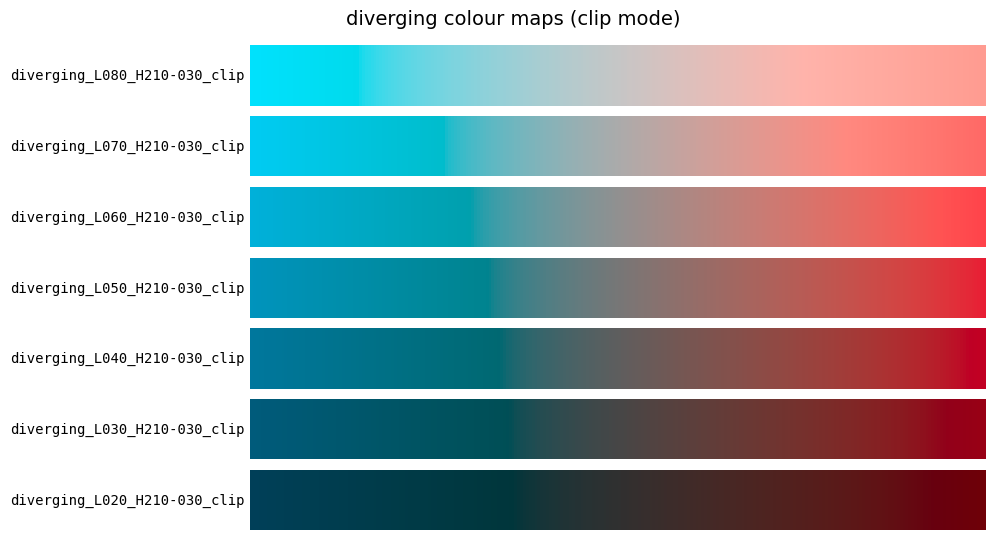

In [34]:
maps.plot_cmaps(filters=['clip'],figsize=(figsize_cmp_x,figsize_cmp_y*7), dpi=dpi, dir=png_dir, title="diverging colour maps (clip mode)")

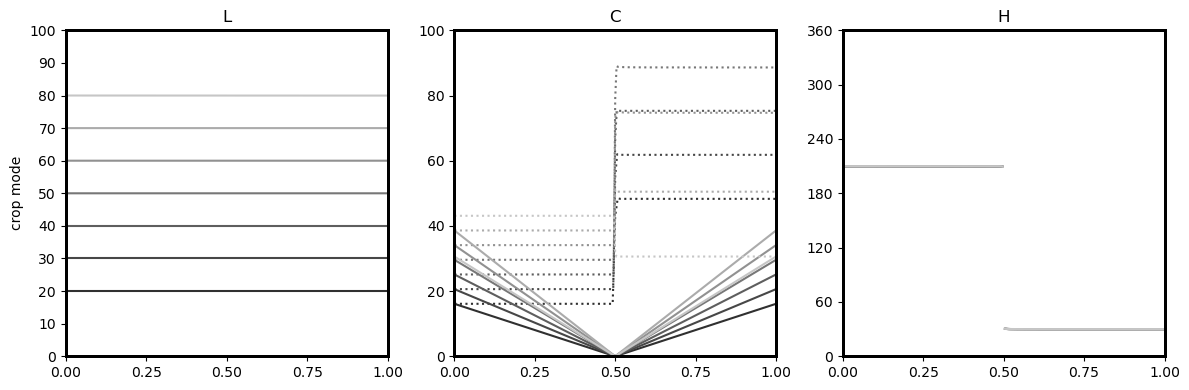

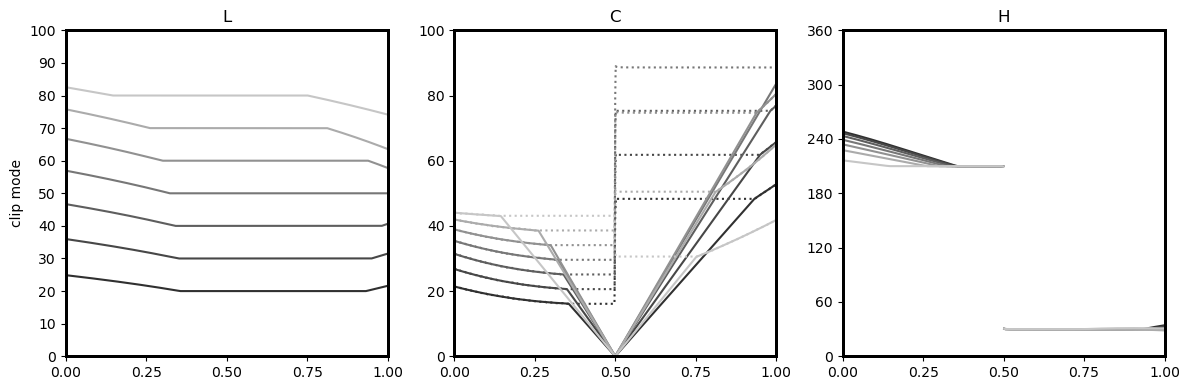

In [35]:
L = np.arange(20,90,10)
for mode in ['crop','clip']:
    axes=[]
    for i in range(len(L)):
        RGB_i = convert.LCH2RGB(L[i],0,0)
        axes = maps.plot_path("diverging_L%03i_H210-030_%s"%(L[i],mode), space='LCH', stack='H', axes=axes, colours=[RGB_i], title="%s mode"%mode)

## Mono-hue cmaps

Function ```make_cmap_monohue()```, for a given H, draws a path from L[0] to L[1] at the maximal C. 
(if ```sym==True``` then Cmax is set for both L and 100-L, otherwise for each L independently).

In [36]:
maps.make_cmap_monohue(H=40, L=[  0, 50], Lres=1, sym=True, png_dir=png_dir)
maps.make_cmap_monohue(H=40, L=[100, 50], Lres=1, sym=True, png_dir=png_dir)
maps.make_cmap_monohue(H=40, L=[  0,100], Lres=1, sym=True, png_dir=png_dir)

creating cmap 'monohue_L000-050_H040_clip' for Matplotlib (  51 steps)
writing ./maps/cmap_monohue_L000-050_H040_clip.png (32x51)
creating cmap 'monohue_L000-050_H040_crop' for Matplotlib (  51 steps)
writing ./maps/cmap_monohue_L000-050_H040_crop.png (32x51)
creating cmap 'monohue_L100-050_H040_clip' for Matplotlib (  51 steps)
writing ./maps/cmap_monohue_L100-050_H040_clip.png (32x51)
creating cmap 'monohue_L100-050_H040_crop' for Matplotlib (  51 steps)
writing ./maps/cmap_monohue_L100-050_H040_crop.png (32x51)
creating cmap 'monohue_L000-100_H040_clip' for Matplotlib ( 101 steps)
writing ./maps/cmap_monohue_L000-100_H040_clip.png (32x101)
creating cmap 'monohue_L000-100_H040_crop' for Matplotlib ( 101 steps)
writing ./maps/cmap_monohue_L000-100_H040_crop.png (32x101)


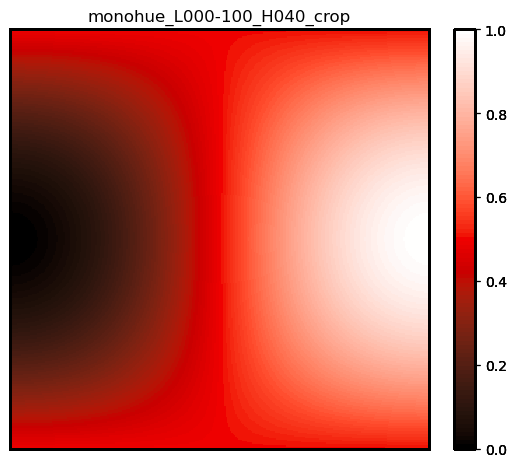

In [37]:
maps.test_cmaps(names=["monohue_L000-050_H040_crop","monohue_L100-050_H040_crop","monohue_L000-100_H040_crop"],figsize=figsize_test,fname="")

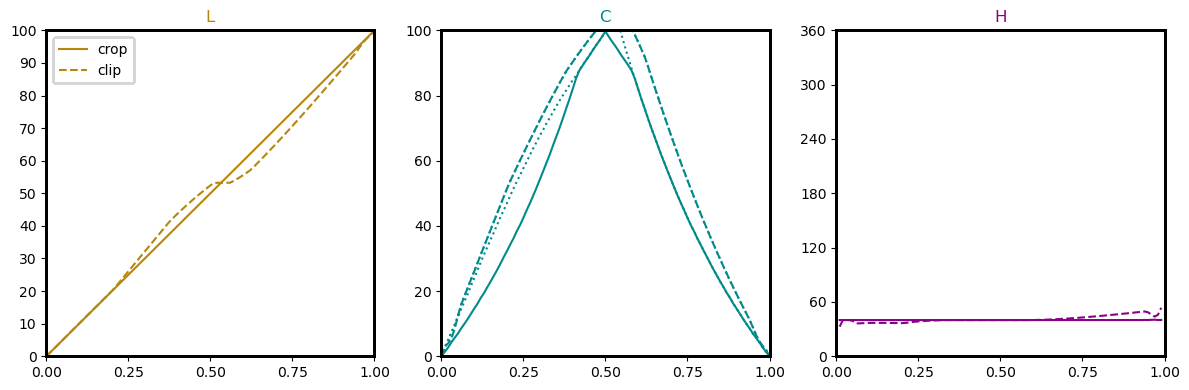

In [38]:
axes = maps.plot_path("monohue_L000-100_H040_crop", space='LCH', stack='H', axes=[]  , styles=['-' ], legend_label='crop')
axes = maps.plot_path("monohue_L000-100_H040_clip", space='LCH', stack='H', axes=axes, styles=['--'], legend_label='clip', legend_loc='upper left')

When using such cmaps hue can be used to code something other than the data value, e.g. a data category.

A selection

In [39]:
maps.make_cmap_favs(types=['monohue'], modes=['crop','clip'], targets=['mpl'], plot=False)

-------
monohue
-------
creating cmap 'monohue_L000-050_H040_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L100-050_H040_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-100_H040_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-050_H100_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L100-050_H100_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-100_H100_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-050_H160_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L100-050_H160_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-100_H160_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-050_H220_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L100-050_H220_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-100_H220_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L000-050_H280_crop' for Matplotlib ( 501 steps)
creating cmap 'monohue_L100-050_H280_crop' for Matplo

found cmaps:  ['monohue_L100-050_H040_crop', 'monohue_L100-050_H100_crop', 'monohue_L100-050_H160_crop', 'monohue_L100-050_H220_crop', 'monohue_L100-050_H280_crop', 'monohue_L100-050_H340_crop']
writing  ./maps/cmap256_monohue_L100-050_H040_crop.png
writing  ./maps/cmap256_monohue_L100-050_H100_crop.png
writing  ./maps/cmap256_monohue_L100-050_H160_crop.png
writing  ./maps/cmap256_monohue_L100-050_H220_crop.png
writing  ./maps/cmap256_monohue_L100-050_H280_crop.png
writing  ./maps/cmap256_monohue_L100-050_H340_crop.png
writing  ./maps/cmaps_mono-hue colour maps, white to hue (crop mode).png


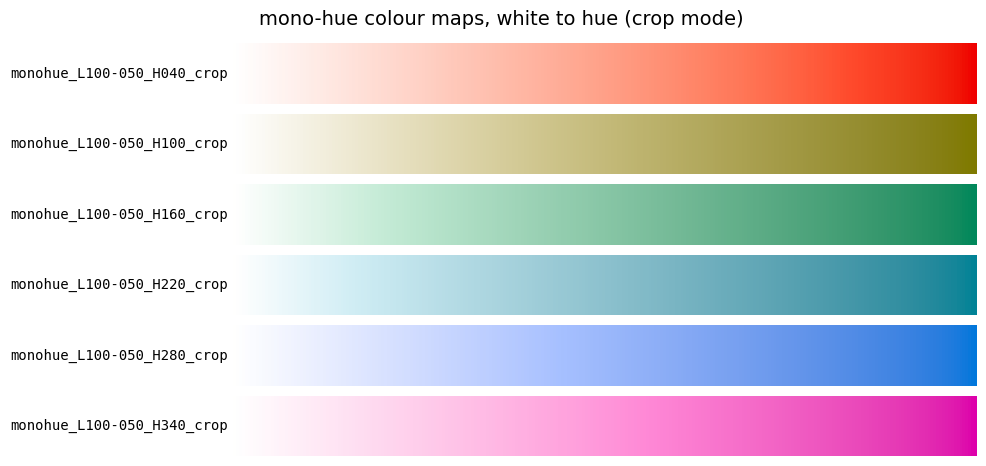

In [40]:
maps.plot_cmaps(filters=["L100-050","crop"],figsize=(figsize_cmp_x,figsize_cmp_y*6), dpi=dpi, dir=png_dir, title="mono-hue colour maps, white to hue (crop mode)")

found cmaps:  ['monohue_L100-050_H040_clip', 'monohue_L100-050_H100_clip', 'monohue_L100-050_H160_clip', 'monohue_L100-050_H220_clip', 'monohue_L100-050_H280_clip', 'monohue_L100-050_H340_clip']
writing  ./maps/cmap256_monohue_L100-050_H040_clip.png
writing  ./maps/cmap256_monohue_L100-050_H100_clip.png
writing  ./maps/cmap256_monohue_L100-050_H160_clip.png
writing  ./maps/cmap256_monohue_L100-050_H220_clip.png
writing  ./maps/cmap256_monohue_L100-050_H280_clip.png
writing  ./maps/cmap256_monohue_L100-050_H340_clip.png
writing  ./maps/cmaps_mono-hue colour maps, white to hue (clip mode).png


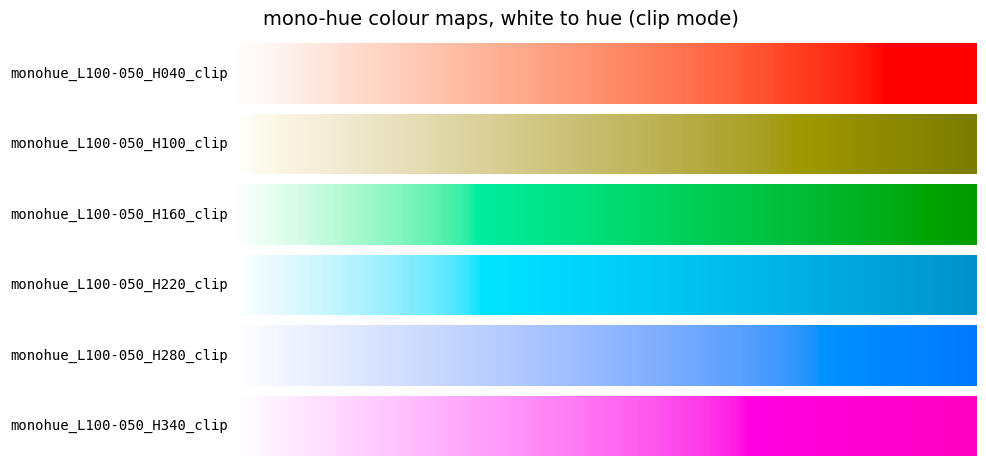

In [41]:
maps.plot_cmaps(filters=["L100-050","clip"],figsize=(figsize_cmp_x,figsize_cmp_y*6), dpi=dpi, dir=png_dir, title="mono-hue colour maps, white to hue (clip mode)")

found cmaps:  ['monohue_L000-050_H040_crop', 'monohue_L000-050_H100_crop', 'monohue_L000-050_H160_crop', 'monohue_L000-050_H220_crop', 'monohue_L000-050_H280_crop', 'monohue_L000-050_H340_crop']
writing  ./maps/cmap256_monohue_L000-050_H040_crop.png
writing  ./maps/cmap256_monohue_L000-050_H100_crop.png
writing  ./maps/cmap256_monohue_L000-050_H160_crop.png
writing  ./maps/cmap256_monohue_L000-050_H220_crop.png
writing  ./maps/cmap256_monohue_L000-050_H280_crop.png
writing  ./maps/cmap256_monohue_L000-050_H340_crop.png
writing  ./maps/cmaps_mono-hue colour maps, black to hue (crop mode).png


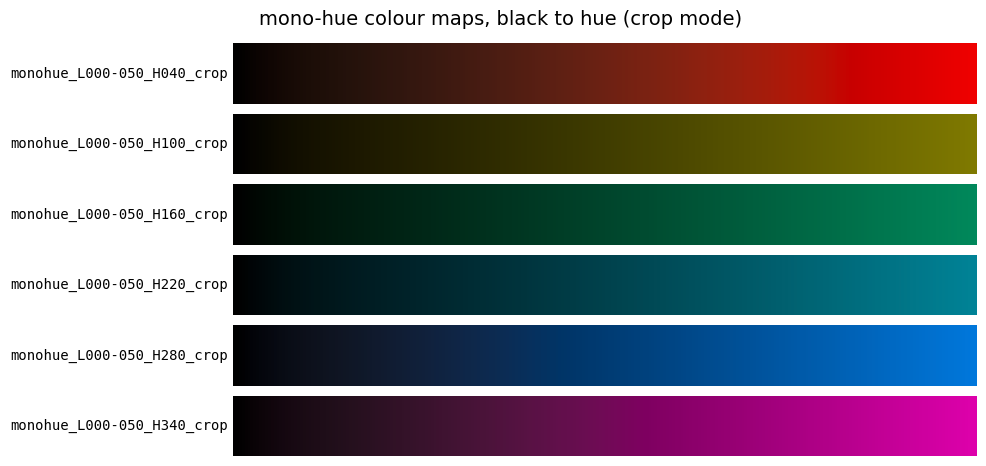

In [42]:
maps.plot_cmaps(filters=["L000-050","crop"],figsize=(figsize_cmp_x,figsize_cmp_y*6), dpi=dpi, dir=png_dir, title="mono-hue colour maps, black to hue (crop mode)")

found cmaps:  ['monohue_L000-050_H040_clip', 'monohue_L000-050_H100_clip', 'monohue_L000-050_H160_clip', 'monohue_L000-050_H220_clip', 'monohue_L000-050_H280_clip', 'monohue_L000-050_H340_clip']
writing  ./maps/cmap256_monohue_L000-050_H040_clip.png
writing  ./maps/cmap256_monohue_L000-050_H100_clip.png
writing  ./maps/cmap256_monohue_L000-050_H160_clip.png
writing  ./maps/cmap256_monohue_L000-050_H220_clip.png
writing  ./maps/cmap256_monohue_L000-050_H280_clip.png
writing  ./maps/cmap256_monohue_L000-050_H340_clip.png
writing  ./maps/cmaps_mono-hue colour maps, black to hue (clip mode).png


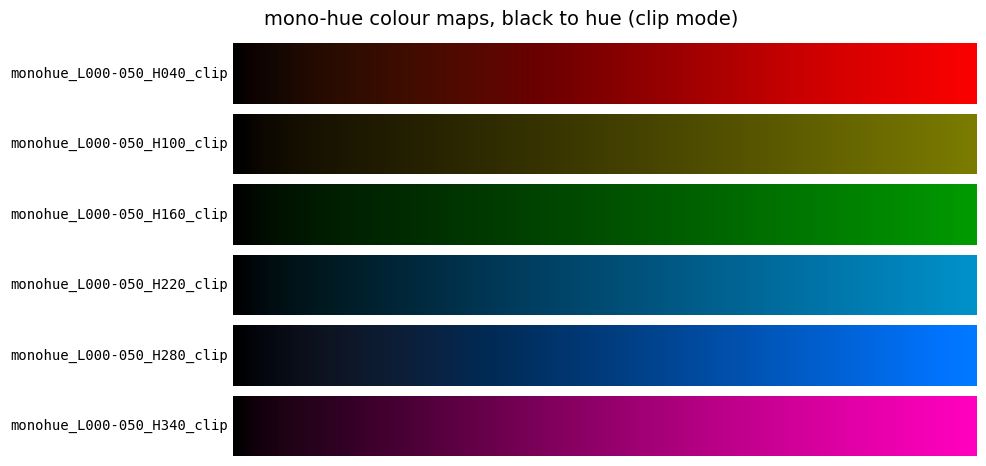

In [43]:
maps.plot_cmaps(filters=["L000-050","clip"],figsize=(figsize_cmp_x,figsize_cmp_y*6), dpi=dpi, dir=png_dir, title="mono-hue colour maps, black to hue (clip mode)")

found cmaps:  ['monohue_L000-100_H040_crop', 'monohue_L000-100_H100_crop', 'monohue_L000-100_H160_crop', 'monohue_L000-100_H220_crop', 'monohue_L000-100_H280_crop', 'monohue_L000-100_H340_crop']
writing  ./maps/cmap256_monohue_L000-100_H040_crop.png
writing  ./maps/cmap256_monohue_L000-100_H100_crop.png
writing  ./maps/cmap256_monohue_L000-100_H160_crop.png
writing  ./maps/cmap256_monohue_L000-100_H220_crop.png
writing  ./maps/cmap256_monohue_L000-100_H280_crop.png
writing  ./maps/cmap256_monohue_L000-100_H340_crop.png
writing  ./maps/cmaps_mono-hue colour maps, black to hue to white (crop mode).png


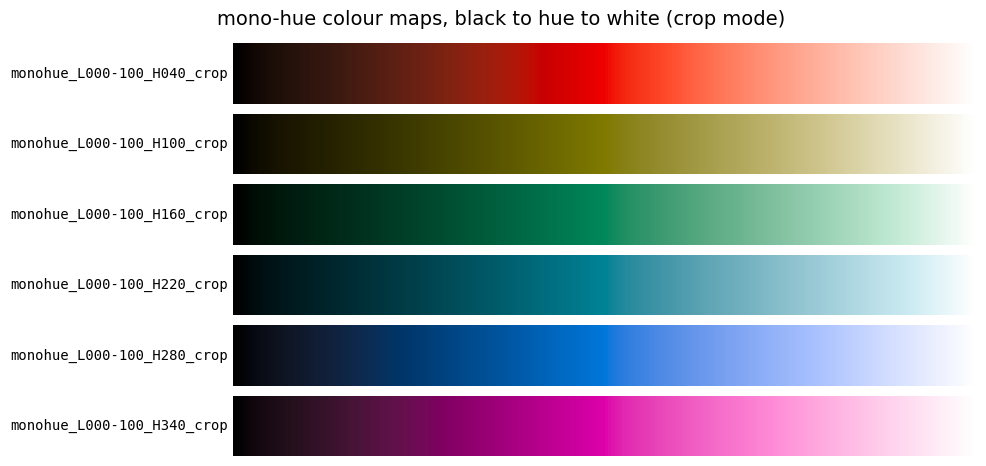

In [44]:
maps.plot_cmaps(filters=["L000-100","crop"],figsize=(figsize_cmp_x,figsize_cmp_y*6), dpi=dpi, dir=png_dir, title="mono-hue colour maps, black to hue to white (crop mode)")

found cmaps:  ['monohue_L000-100_H040_clip', 'monohue_L000-100_H100_clip', 'monohue_L000-100_H160_clip', 'monohue_L000-100_H220_clip', 'monohue_L000-100_H280_clip', 'monohue_L000-100_H340_clip']
writing  ./maps/cmap256_monohue_L000-100_H040_clip.png
writing  ./maps/cmap256_monohue_L000-100_H100_clip.png
writing  ./maps/cmap256_monohue_L000-100_H160_clip.png
writing  ./maps/cmap256_monohue_L000-100_H220_clip.png
writing  ./maps/cmap256_monohue_L000-100_H280_clip.png
writing  ./maps/cmap256_monohue_L000-100_H340_clip.png
writing  ./maps/cmaps_mono-hue colour maps, black to hue to white (clip mode).png


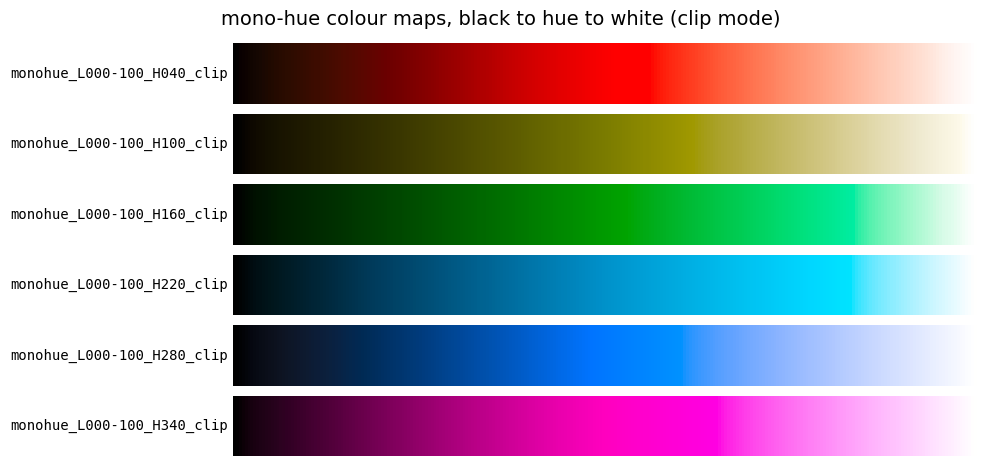

In [45]:
maps.plot_cmaps(filters=["L000-100","clip"],figsize=(figsize_cmp_x,figsize_cmp_y*6), dpi=dpi, dir=png_dir, title="mono-hue colour maps, black to hue to white (clip mode)")

Note: the difference between `crop` and `clip` modes is particularly visible for the greens (at H=160). Looking back at the sRGB and full gamut, we see that their peaks overlap reasonably well in the reds and blues regions, but not in the greens. When represented in the CIE horseshoe diagram, the sRGB gamut is much lacking in the greens.

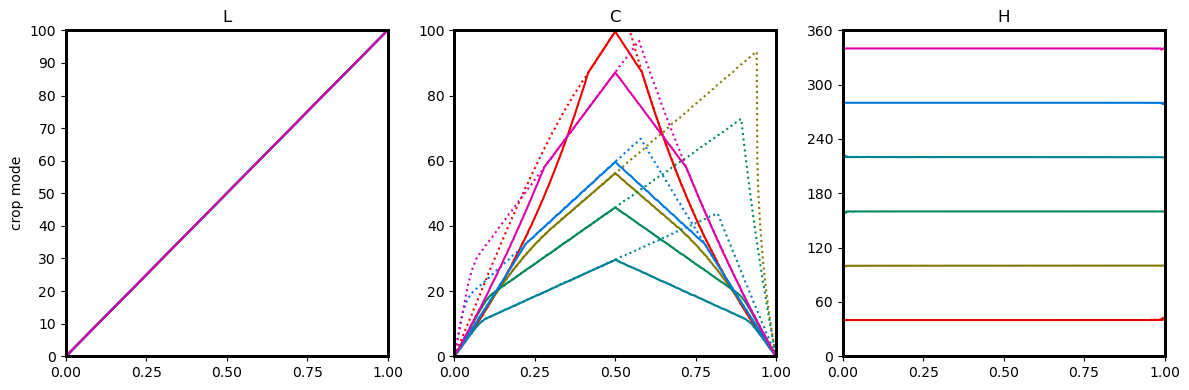

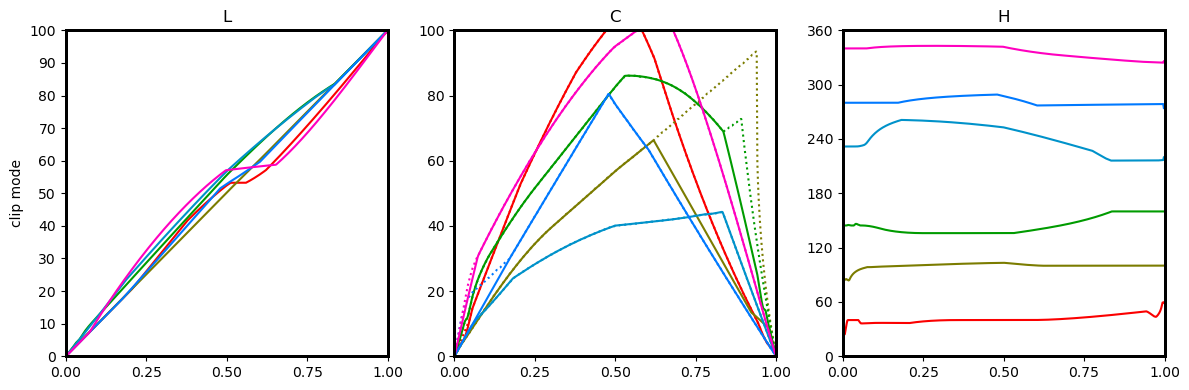

In [46]:
H = 40 + 60*np.arange(6)
for mode in ['crop','clip']:
    axes=[]
    for i in range(len(H)):
        L_i = 50
        C_max_i = maps.Cmax_for_LH[mode](L_i,H[i])
        RGB_i = convert.clip3(convert.LCH2RGB(L_i,C_max_i,H[i]))
        axes = maps.plot_path("monohue_L000-100_H%03i_%s"%(H[i],mode), space='LCH', stack='H', axes=axes, colours=[RGB_i], title="%s mode"%mode)

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img align="left" alt="Creative Commons License" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br>
<br>Gilles Ferrand
<br>2020-08-18